In [1]:
from global_vars import *
from func import *

import pickle as p
import glob 
import json
import subprocess
import getpass
import os

In [2]:
# ",".join(os.listdir('/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/lablmaps/UKB'))
vol_to_check_list = None

In [3]:
data_dir

'/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti'

In [4]:
def load_ukb_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if vol == "":
            continue
        opp_paths = glob.glob(f'{data_dir}/{vol}/**opp**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/**in**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/**F**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/**W**.nii.gz')
        
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths
        

In [ ]:
file_paths = load_ukb_file_paths()

In [ ]:
 print(json.dumps(file_paths,sort_keys=True, indent=4))

In [ ]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [ ]:
# TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.

for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'applying n4 bias field on opp scans of {vol}...')
    vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
    idx = 0
    file_paths[vol]['N4_1'] = []
    for opp_img, bias_field_img, opp_file in vol_parts:
        file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
        idx+=1
#         n4_dict[vol].append(rescale(opp_image, vol, n4_dict[vol]))



In [ ]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    print(f'started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
#     file_paths[vol]['ONE_ORIG'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
#         save_volume(ras_stitched_orig, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'
#         file_paths[vol]['ONE_ORIG'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig.nii.gz'

In [ ]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

In [ ]:
# TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'applying n4 bias field on stitched opp scans of {vol}...')

    opp_file = file_paths[vol]['ONE']['OPP']
    n4_counterpart = n4_dict[vol]['N4_2']
    print(opp_file, n4_counterpart['IN_BIAS'])
    opp_img = read_ras(opp_file)
    bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

    file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

In [ ]:
with open('nako_file_paths.p', 'wb') as handle:
    p.dump(file_paths, handle, protocol=p.HIGHEST_PROTOCOL)

In [5]:
with open('nako_file_paths.p', 'rb') as handle:
    file_paths = p.load(handle)

In [6]:
print(json.dumps(file_paths, indent=4))

{
    "1138634_20201_2_0": {
        "VOLUME_PATHS": {
            "OPP": [
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17s.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sa.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_noBH_opp_Dixon_noBH.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_noBH_opp_Dixon_noBHa.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_noBH_opp_Dixon_noBHb.nii.gz"
            ],
            "IN": [
                "/home/abhijit/nas_drive/Data_WholeBody/UKBioban

In [ ]:
def ukb_vol_label_fix(vol, label):
    vol_vol = np.product(vol.shape)
    label_vol = np.product(label.shape)
    
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    print(tuple(world_shape))
    final_label = np.zeros(tuple(world_shape))
    
    label_affine = label.affine
    vol_affine = vol.affine
    if(vol_vol>label_vol):
#         final_label = np.zeros(vol.shape)
        target_affine = vol_affine
        target_header = vol.header
        target_dim_v = vol.shape
        
#         labelmap2vol = npl.inv(target_affine).dot(label_affine)
#         start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
#         sx, sy,sz = start_inv
#         end_inv = apply_affine(labelmap2vol, target_dim_v).astype(np.int32)
#         final_label = np.zeros(end_inv)
#         ex, ey, ez = end_inv
#         print("seg start inv v: ",start_inv , "segm end inv v:",end_inv)
        sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))
        print(sx,sy,sz,ex,ey,ez)
        final_label[0:ex+sx, 0:ey+sy, sz:ez] = label.get_fdata()
        final_label = np.flip(final_label, axis=0)
        final_label = np.flip(final_label, axis=1)
        final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
        volume, label = vol, final_label_img
    else:
#         final_label = np.zeros(label.shape)
        target_affine = label_affine
        target_header = label.header
        target_dim_v = label.shape
        
#         labelmap2vol = npl.inv(target_affine).dot(vol_affine)
#         start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
#         sx, sy,sz = start_inv
#         end_inv = apply_affine(labelmap2vol, target_dim_v).astype(np.int32)
#         final_label = np.zeros(end_inv)
#         ex, ey, ez = end_inv
#         print("seg start inv v: ",start_inv , "segm end inv v:",end_inv)
        sx,sy,sz,ex,ey,ez = np.abs(get_points(vol, label))
        print(sx,sy,sz,ex,ey,ez)
        final_label = np.flip(final_label, axis=0)
        final_label = np.flip(final_label, axis=1)
        final_label[0:ex+sx, 0:ey+sy, sz:ez] = vol.get_fdata()
        
        final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
        volume, label = final_label_img, label
    
    return volume, label

def get_freequent_shape(arr, axis=0):
    arr = np.array(arr)
    print(arr)
    u, indices = np.unique(arr, return_inverse=True)
    f_shape = u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape),
                                    None, np.max(indices) + 1), axis=axis)]
    print(f_shape)
    return f_shape

def label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = get_freequent_shape([img.shape for img, _, _ in label_parts])##np.max([img.shape for img, _, _ in label_parts], axis=0)
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape
    print('final_label_stitching shape:',label_shape)
    print('reference label shape:', len(label_parts), reference_labelmap.shape)
    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print('lp:bfr:', lidx, lname, labelmap_img.shape, np.unique(labelmap_img.get_fdata()))
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        print(np.unique(labelmap_img.get_fdata()), labelmap_img.shape)
        
        sx,sy,sz,ex,ey,ez = get_points(labelmap_img, reference_labelmap)
        sx,sy,sz,ex,ey,ez = np.abs([sx,sy,sz,ex,ey,ez])
        print('label_points:', sx,sy,sz,ex,ey,ez)
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        x, y, z = labelmap.shape
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

In [ ]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    later = None
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
        
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if labelname is None or img_ras is None:
            continue
        print(img_ras.shape)
        img_ras = makeit_3d(img_ras)
        print('After 3d confirmed:', img_ras.shape)
        mode='constant'
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=0, mode=mode, cval=0.0)
#         img_ras = labels_integerify(img_ras)
    #     img_ras = resample_from_to(img_ras, [volume.shape, img_ras.affine])
        if labelname == 'SPLEEN':
            later = [img_ras, lidx, labelname]
        else:
            img_ras_list.append([img_ras, lidx, labelname])
    if later is not None:
        img_ras_list.append(later)
        
    s_label = label_parts(img_ras_list)
    volume, s_label = ukb_vol_label_fix(volume, s_label)
    #     volume, stitched_label = combine_nako_seg(file_paths[vol]['LABEL_PATHS'],'' ,file_paths[vol]['N4_2']['OPP_CORRECTED'])

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))

    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    print('FINISHED.')
    
    


1138634_20201_2_0


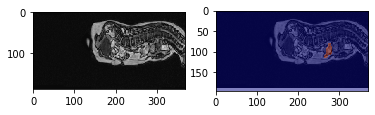

3387088_20201_2_0


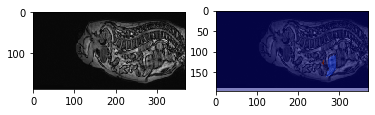

1942395_20201_2_0


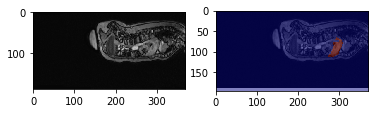

1019631_20201_2_0


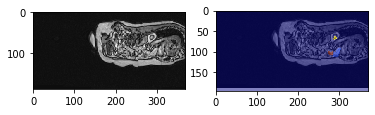

5764643_20201_2_0


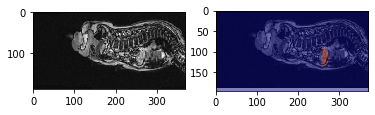

1013250_20201_2_0


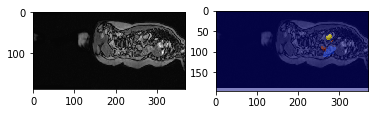

1584559_20201_2_0


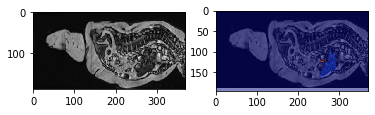

1013391_20201_2_0


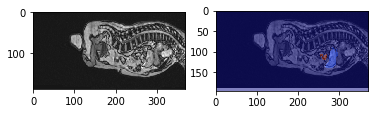

1108214_20201_2_0


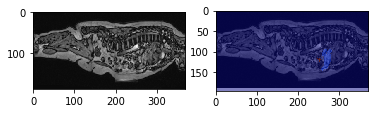

5397022_20201_2_0


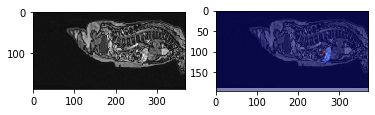

5934622_20201_2_0


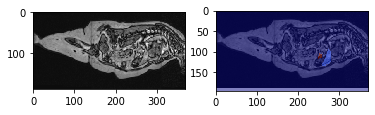

4154467_20201_2_0


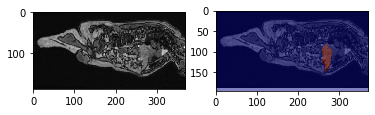

1026125_20201_2_0


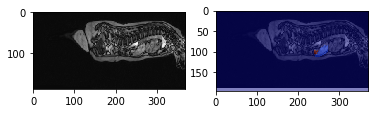

1005379_20201_2_0


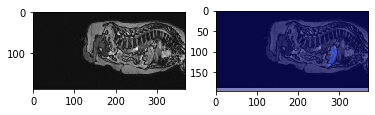

5371767_20201_2_0


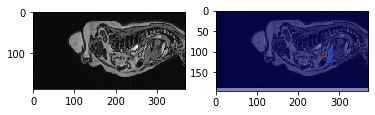

4627690_20201_2_0


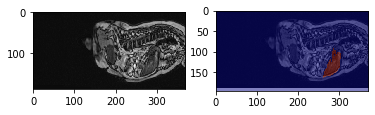

1883132_20201_2_0


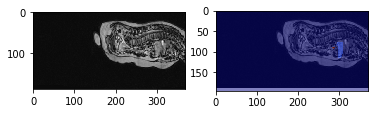

1004985_20201_2_0


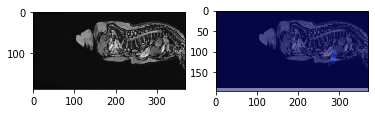

1036900_20201_2_0


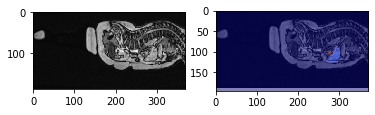

5833278_20201_2_0


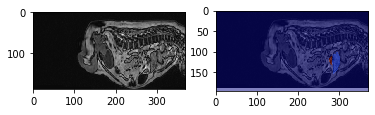

1003082_20201_2_0


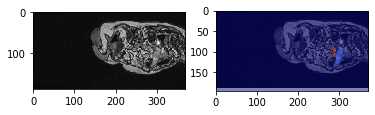

6025746_20201_2_0


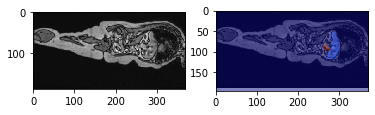

5331775_20201_2_0


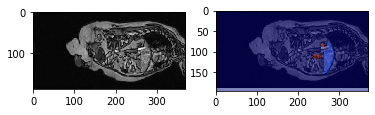

1004466_20201_2_0
No such file or no access: 'temp/UKB/processed/volume/1004466_20201_2_0.nii.gz'
1002359_20201_2_0


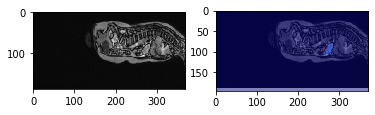

In [7]:
visualize_overlay(file_paths)

In [ ]:
print(json.dumps(file_paths, indent=4))

In [ ]:
# file_dict= 
# {
#     VOL_ID: {
#         VOLUME_PATHS: {
#             OPP: [],
#             IN: [],
#             F: [],
#             W: []
#         },
#         LABEL_PATHS: [],
#         N4_1: [
#             {
#                 SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#                 IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#                 IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#                 OPP_CORRECTED: '',
#                 MIN: u_min,
#                 MAX: u_max
#             },
#             {},
#             {}
#         ],
#         ONE: {
#             OPP: '',
#             IN: '',
#             F: '',
#             W: '',
#         },
#         N4_2: {
#             SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#             IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#             IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#             OPP_CORRECTED: '',
#             MIN: u_min,
#             MAX: u_max
#         },
        
#     }
# }